
=== Strategy Summary (Terminal Wealth) ===
                                 mean       median          std         p5        p25          p75          p95
strategy                                                                                                       
Buy and Hold             1,473,115.56 1,081,980.34 1,514,634.27 361,745.25 654,566.74 1,888,543.89 3,734,925.91
MA(50/200) Long/Cash     1,175,388.98   927,993.17   942,355.71 419,253.74 651,338.30 1,432,689.74 2,600,421.99
Momentum(12m) Long/Cash  1,171,098.35   894,353.07   950,954.41 428,518.96 629,006.73 1,391,575.79 2,702,591.85
MA(50/200) Long/Short    1,247,207.94   937,725.68 1,004,907.48 352,390.96 600,304.15 1,522,573.31 3,164,148.62
Momentum(12m) Long/Short   716,052.74   519,835.29   620,838.10 224,758.19 348,668.22   853,434.82 1,900,283.32

=== Pairwise Outperformance (B vs A) ===
                      A                        B  prob_B_outperforms_A  avg_B_minus_A  median_B_minus_A
           Buy and Hold   

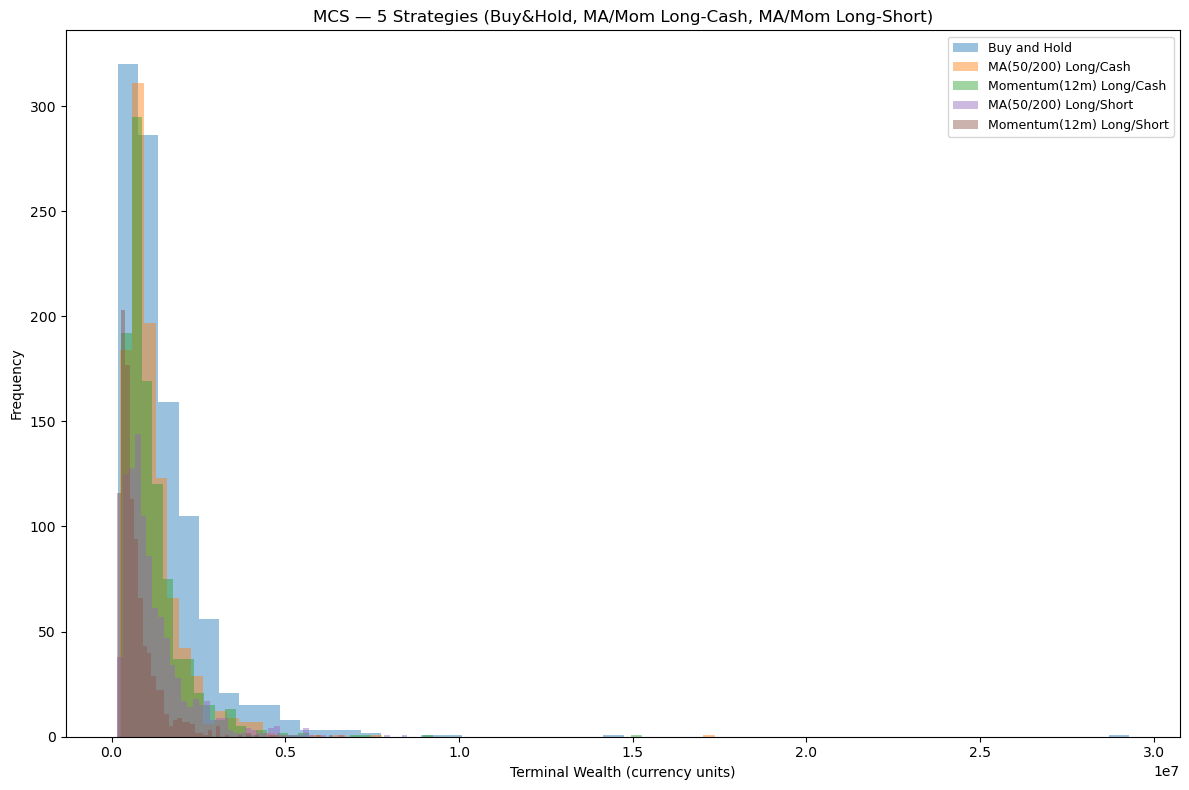

In [1]:

#!/usr/bin/env python3
"""
MCS (5 strategies): Buy&Hold vs MA(50/200) Long/Cash vs Momentum(12m) Long/Cash
                  vs MA(50/200) Long/Short vs Momentum(12m) Long/Short

- Uses daily block bootstrap to preserve serial dependence; recomputes signals per path.
- Signals are shifted (daily: 1 day; monthly: 1 month) to avoid look-ahead.
- Long/Cash: out of market earns cash. Long/Short: short months earn -(eq_r) plus (rebate - borrow).

Outputs:
  - summary_mcs_5.csv       : terminal wealth distribution stats per strategy
  - pairs_mcs_5.csv         : B vs A outperformance probabilities and differences
  - wealth_hist_mcs_5.png   : histogram comparison of terminal wealth

Author: (your name)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ------------------- CONFIG -------------------
CONFIG = {
    "data": {
        # Mode: "csv" (provide file) or "simulate"
        "mode": "simulate",                 # set to "csv" when you provide a file
        "csv_path": "prices.csv",           # CSV columns required: date, close (daily)
        "gbm": {                            # GBM fallback if mode="simulate"
            "annual_mu": 0.08,              # drift (8% p.a.)
            "annual_sigma": 0.20,           # vol (20% p.a.)
            "start_price": 100.0
        }
    },
    "simulation": {
        "months": 360,        # 30 years horizon
        "n_paths": 1000,      # Monte Carlo paths
        "block_days": 60,     # bootstrap block length (~3 trading months)
        "seed": 42
    },
    "cash": {
        "annual_rf": 0.03     # cash (risk-free) annual rate used when flat; also default rebate
    },
    "shorting": {
        "enabled": True,
        "rebate_annual": None,     # if None, uses cash. Interest on short proceeds
        "borrow_spread_annual": 0.01,  # additional annual borrow cost (e.g., 1%)
        "transaction_cost_bps": 5,     # one cost applied on signal change (round-trip simplified)
        "neutral_threshold_pct": 0.0    # optional band for MA L/S to reduce churn
    },
    "contributions": {
        "base_monthly": 1000.0,
        "annual_raise": {"pct": 0.02, "apply_in_month": 1},  # January raise
        "bonus_months": [
            # Example: {"month": 12, "amount": 5000.0}
        ]
    },
    "outputs": {
        "summary_csv": "summary_mcs_5.csv",
        "pairs_csv": "pairs_mcs_5.csv",
        "plot_png": "wealth_hist_mcs_5.png",
        "plot_title": "MCS — 5 Strategies (Buy&Hold, MA/Mom Long-Cash, MA/Mom Long-Short)"
    }
}
# ---------------- END CONFIG ------------------


# ---------------- Utility ----------------
def load_daily_prices(cfg) -> pd.Series:
    """Return daily close prices as Series with DatetimeIndex."""
    sim_cfg = cfg["simulation"]
    months = int(sim_cfg["months"])
    trading_days = int(months * 21)  # ~21 trading days per month
    buffer_days = 400                # extra days for rolling windows

    mode = cfg["data"]["mode"]
    if mode == "csv":
        df = pd.read_csv(cfg["data"]["csv_path"])
        if "date" not in df.columns or "close" not in df.columns:
            raise ValueError("CSV must contain columns: 'date', 'close'.")
        px = pd.Series(df["close"].values, index=pd.to_datetime(df["date"])).sort_index()
        return px
    elif mode == "simulate":
        gbm = cfg["data"]["gbm"]
        mu_a = float(gbm["annual_mu"])
        sig_a = float(gbm["annual_sigma"])
        S0 = float(gbm["start_price"])

        dt = 1.0 / 252.0
        n_days = trading_days + buffer_days
        np.random.seed(cfg["simulation"]["seed"])
        Z = np.random.normal(0, 1, size=n_days)
        log_inc = (mu_a - 0.5 * sig_a**2) * dt + sig_a * np.sqrt(dt) * Z

        S = np.zeros(n_days + 1)
        S[0] = S0
        for t in range(n_days):
            S[t + 1] = S[t] * np.exp(log_inc[t])

        idx = pd.date_range(start="2000-01-01", periods=n_days + 1, freq="B")
        return pd.Series(S, index=idx)
    else:
        raise ValueError("CONFIG['data']['mode'] must be 'csv' or 'simulate'.")


def monthly_cash_return(annual_rf: float) -> float:
    """Annual → monthly simple rate."""
    return (1.0 + annual_rf)**(1.0/12.0) - 1.0


def monthly_spread_return(spread_annual: float) -> float:
    """Annual spread → monthly simple rate."""
    return (1.0 + spread_annual)**(1.0/12.0) - 1.0


def make_contrib_vector(months: int, base: float,
                        annual_raise_pct: float = 0.0,
                        apply_in_month: int = 1,
                        bonus_months=None) -> np.ndarray:
    if bonus_months is None:
        bonus_months = []
    contrib = np.zeros(months)
    base_current = base
    for t in range(months):
        cal_m = (t % 12) + 1
        contrib[t] += base_current
        for bm in bonus_months:
            if int(bm.get("month", 0)) == cal_m:
                contrib[t] += float(bm.get("amount", 0.0))
        if cal_m == int(apply_in_month) and annual_raise_pct and t < months - 1:
            base_current *= (1.0 + annual_raise_pct)
    return contrib


# ---------------- Signals ----------------
def ma_crossover_exposure_daily(px: pd.Series, fast=50, slow=200) -> pd.Series:
    """
    Daily Long/Cash exposure: 1 if MA(fast) > MA(slow), else 0.
    """
    ma_fast = px.rolling(fast, min_periods=fast).mean()
    ma_slow = px.rolling(slow, min_periods=slow).mean()
    exp_daily = (ma_fast > ma_slow).astype(int)
    return exp_daily


def ma_long_short_daily(px: pd.Series, fast=50, slow=200, neutral_threshold_pct=0.0) -> pd.Series:
    """
    Daily Long/Short exposure in {-1, 0, +1} based on MA(fast) vs MA(slow).
    +1 if fast > slow*(1 + threshold), -1 if fast < slow*(1 - threshold), else 0.
    """
    ma_fast = px.rolling(fast, min_periods=fast).mean()
    ma_slow = px.rolling(slow, min_periods=slow).mean()

    up_cut = ma_slow * (1.0 + float(neutral_threshold_pct))
    dn_cut = ma_slow * (1.0 - float(neutral_threshold_pct))

    exp = pd.Series(index=px.index, dtype="float64")
    exp[ma_fast > up_cut] = 1.0
    exp[ma_fast < dn_cut] = -1.0
    exp[(ma_fast <= up_cut) & (ma_fast >= dn_cut)] = 0.0
    return exp.astype(float)  # keep float until monthly resample


def monthly_exposure_from_daily_signal(exp_daily: pd.Series) -> pd.Series:
    """
    For Long/Cash daily signals (0/1):
    Shift by one day (avoid look-ahead), then last signal each month → {0,1}.
    """
    exp_m = exp_daily.shift(1).resample("ME").last().dropna()
    exp_m = exp_m.ffill().fillna(0).astype(int)
    return exp_m


def daily_to_monthly_exposure(exp_daily_ls: pd.Series) -> pd.Series:
    """
    For Long/Short daily signals (-1/0/+1):
    Shift by one day (avoid look-ahead), then last signal each month → {-1,0,+1}.
    """
    exp_m = exp_daily_ls.shift(1).resample("ME").last().dropna()
    exp_m = exp_m.ffill().fillna(0).astype(float)
    # clip rounding issues and cast
    exp_m = exp_m.clip(lower=-1, upper=1).round()
    return exp_m.astype(int)


def momentum_long_cash_monthly(px_m: pd.Series, lookback_months=12) -> pd.Series:
    """
    Monthly Momentum Long/Cash:
      exposure = 1 if 12m change > 0 else 0.
    Shift by one month to avoid look-ahead. Any NaNs/inf become 0 (flat).
    """
    mom = (px_m / px_m.shift(lookback_months)) - 1.0
    mom_clean = mom.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    exp_m = (mom_clean > 0).astype(int).shift(1)
    exp_m = exp_m.ffill().fillna(0).astype(int)
    return exp_m


def momentum_long_short_monthly(px_m: pd.Series, lookback_months=12) -> pd.Series:
    """
    Monthly Momentum Long/Short:
      exposure = sign(12m change) in {-1, 0, +1}.
    Shift by one month to avoid look-ahead. Any NaNs/inf become 0 (flat).
    """
    mom = (px_m / px_m.shift(lookback_months)) - 1.0
    mom_clean = mom.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    exp_m = pd.Series(np.sign(mom_clean), index=mom_clean.index).shift(1)
    exp_m = exp_m.fillna(0).astype(int)
    return exp_m


# ---------------- Bootstrap & Reconstruction ----------------
def block_bootstrap_daily(daily_ret: pd.Series, n_days: int, block: int, rng: np.random.Generator) -> pd.Series:
    r = daily_ret.dropna().to_numpy()
    N = len(r)
    if N < block:
        raise ValueError(f"Insufficient history ({N} < block {block}).")
    max_start = N - block

    chunks = []
    total = 0
    while total < n_days:
        s = rng.integers(0, max_start + 1)
        chunk = r[s:s+block]
        chunks.append(chunk)
        total += len(chunk)

    out = np.concatenate(chunks, axis=0)[:n_days]
    idx = pd.date_range(start="1900-01-01", periods=n_days, freq="B")
    return pd.Series(out, index=idx)


def rebuild_price_from_returns(r_daily: pd.Series, S0: float) -> pd.Series:
    S = np.empty(len(r_daily) + 1)
    S[0] = S0
    for i, ret in enumerate(r_daily.values):
        S[i+1] = S[i] * (1.0 + ret)
    idx = pd.date_range(start=r_daily.index[0], periods=len(S), freq="B")
    return pd.Series(S, index=idx)


# ---------------- Strategy Engines ----------------
def apply_buy_and_hold_monthly(eq_r_m: pd.Series, contrib: np.ndarray) -> float:
    months = len(contrib)
    eq_r_m = eq_r_m.iloc[:months]
    W = 0.0
    for t in range(months):
        W += contrib[t]
        W *= (1.0 + eq_r_m.iloc[t])
    return float(W)


def apply_long_cash_monthly(eq_r_m: pd.Series, exp_m: pd.Series, cash_r_m: float, contrib: np.ndarray) -> float:
    """
    Long/Cash strategy:
      If exposure==1 → equity return; else → cash return.
    """
    months = len(contrib)
    eq_r_m = eq_r_m.iloc[:months]
    exp_m = exp_m.iloc[:months]
    W = 0.0
    for t in range(months):
        W += contrib[t]
        ret = eq_r_m.iloc[t] if int(exp_m.iloc[t]) == 1 else cash_r_m
        W *= (1.0 + ret)
    return float(W)


def apply_long_short_monthly(eq_r_m: pd.Series, exp_m: pd.Series,
                             cash_r_m: float, short_rebate_m: float, short_borrow_m: float,
                             tc_bps: float, contrib: np.ndarray) -> float:
    """
    Long/Short monthly wealth update:
      - Add contribution
      - Apply transaction cost when exposure changes (simple % of wealth)
      - Apply return:
           exp = +1  -> +eq_r
           exp =  0  -> +cash_r
           exp = -1  -> -(eq_r) + (short_rebate_m - short_borrow_m)
    """
    months = len(contrib)
    eq_r_m = eq_r_m.iloc[:months]
    exp_m = exp_m.iloc[:months]
    W = 0.0
    tc = float(tc_bps) / 10_000.0

    for t in range(months):
        W += contrib[t]

        # trading cost on signal change
        if t == 0:
            changed = (int(exp_m.iloc[t]) != 0)  # opening trade from flat
        else:
            changed = (int(exp_m.iloc[t]) != int(exp_m.iloc[t-1]))
        if changed and tc > 0:
            W *= (1.0 - tc)

        e = int(exp_m.iloc[t])
        if e == 1:
            ret = eq_r_m.iloc[t]
        elif e == 0:
            ret = cash_r_m
        else:  # e == -1
            ret = -eq_r_m.iloc[t] + (short_rebate_m - short_borrow_m)

        W *= (1.0 + ret)

    return float(W)


# ---------------- Summaries ----------------
def summarize(x: np.ndarray) -> dict:
    return {
        "mean": float(np.mean(x)),
        "median": float(np.median(x)),
        "std": float(np.std(x, ddof=1)),
        "p5": float(np.percentile(x, 5)),
        "p25": float(np.percentile(x, 25)),
        "p75": float(np.percentile(x, 75)),
        "p95": float(np.percentile(x, 95)),
    }


def ensure_len(s: pd.Series, months: int, fill=0):
    """Ensure 's' has exactly 'months' entries on a month-end index."""
    s = s.copy()

    # If missing/incorrect index, coerce to month-end by resampling
    if not isinstance(s.index, pd.DatetimeIndex):
        start = pd.Timestamp("2001-01-31")
        s.index = pd.date_range(start=start, periods=len(s), freq="ME")
    if s.index.freq is None or s.index.freqstr != "ME":
        s = s.resample("ME").last()

    # Trim if longer
    if len(s) >= months:
        return s.iloc[:months]

    # Pad if shorter
    if len(s) > 0:
        last_val = s.iloc[-1] if pd.notna(s.iloc[-1]) else fill
        start_next = s.index[-1] + pd.offsets.MonthEnd(1)
        pad_idx = pd.date_range(start=start_next, periods=(months - len(s)), freq="ME")
        add = pd.Series([last_val] * (months - len(s)), index=pad_idx)
        return pd.concat([s, add])
    else:
        start = pd.Timestamp("2001-01-31")
        idx = pd.date_range(start=start, periods=months, freq="ME")
        return pd.Series([fill] * months, index=idx)


# ---------------- Main ----------------
def run_mcs(cfg):
    # Load base daily prices and build base daily returns
    px_daily = load_daily_prices(cfg)
    r_daily = px_daily.pct_change().dropna().clip(lower=-0.99)

    months = int(cfg["simulation"]["months"])
    n_paths = int(cfg["simulation"]["n_paths"])
    block_days = int(cfg["simulation"]["block_days"])
    seed = int(cfg["simulation"]["seed"])

    # Cash, rebate, borrow (monthly)
    cash_r_m = monthly_cash_return(float(cfg["cash"]["annual_rf"]))
    rebate_annual = cfg["shorting"]["rebate_annual"]
    if rebate_annual is None:
        rebate_annual = float(cfg["cash"]["annual_rf"])
    short_rebate_m = monthly_cash_return(rebate_annual)
    short_borrow_m = monthly_spread_return(float(cfg["shorting"]["borrow_spread_annual"]))
    tc_bps = float(cfg["shorting"]["transaction_cost_bps"])
    neutral_th = float(cfg["shorting"]["neutral_threshold_pct"])

    # Contributions
    contrib = make_contrib_vector(
        months=months,
        base=float(cfg["contributions"]["base_monthly"]),
        annual_raise_pct=float(cfg["contributions"].get("annual_raise", {}).get("pct", 0.0)),
        apply_in_month=int(cfg["contributions"].get("annual_raise", {}).get("apply_in_month", 1)),
        bonus_months=cfg["contributions"].get("bonus_months", []),
    )

    rng = np.random.default_rng(seed)

    # Containers for 5 strategies
    res_buy_hold    = np.zeros(n_paths)
    res_ma_longcash = np.zeros(n_paths)
    res_mom_longcash= np.zeros(n_paths)
    res_ma_longshort= np.zeros(n_paths)
    res_mom_longshort=np.zeros(n_paths)

    for i in range(n_paths):
        # Bootstrap and rebuild a synthetic daily price path
        r_sim = block_bootstrap_daily(r_daily, n_days=months*21 + 250, block=block_days, rng=rng)
        S0 = float(px_daily.iloc[0])
        px_sim = rebuild_price_from_returns(r_sim, S0=S0)

        # Monthly prices & equity returns (sanitize)
        px_sim_m = px_sim.resample("ME").last().dropna()
        px_sim_m = px_sim_m.replace([np.inf, -np.inf], np.nan).dropna()

        eq_r_m = px_sim_m.pct_change().dropna().clip(lower=-0.99)
        eq_r_m = ensure_len(eq_r_m, months, fill=0.0)

        # ---- Long/Cash exposures ----
        exp_daily_ma_lc = ma_crossover_exposure_daily(px_sim, fast=50, slow=200)
        exp_month_ma_lc = monthly_exposure_from_daily_signal(exp_daily_ma_lc)
        exp_month_ma_lc = ensure_len(exp_month_ma_lc.fillna(0).astype(int), months, fill=0).astype(int)

        exp_month_mom_lc = momentum_long_cash_monthly(px_sim_m, lookback_months=12)
        exp_month_mom_lc = ensure_len(exp_month_mom_lc.fillna(0).astype(int), months, fill=0).astype(int)

        # ---- Long/Short exposures ----
        exp_daily_ma_ls = ma_long_short_daily(px_sim, fast=50, slow=200, neutral_threshold_pct=neutral_th)
        exp_month_ma_ls = daily_to_monthly_exposure(exp_daily_ma_ls)
        exp_month_ma_ls = ensure_len(exp_month_ma_ls.fillna(0).astype(int), months, fill=0).astype(int)

        exp_month_mom_ls = momentum_long_short_monthly(px_sim_m, lookback_months=12)
        exp_month_mom_ls = ensure_len(exp_month_mom_ls.fillna(0).astype(int), months, fill=0).astype(int)

        # ---- Strategies ----
        res_buy_hold[i]     = apply_buy_and_hold_monthly(eq_r_m, contrib)
        res_ma_longcash[i]  = apply_long_cash_monthly(eq_r_m, exp_month_ma_lc,  cash_r_m, contrib)
        res_mom_longcash[i] = apply_long_cash_monthly(eq_r_m, exp_month_mom_lc, cash_r_m, contrib)
        res_ma_longshort[i] = apply_long_short_monthly(eq_r_m, exp_month_ma_ls,  cash_r_m, short_rebate_m, short_borrow_m, tc_bps, contrib)
        res_mom_longshort[i]= apply_long_short_monthly(eq_r_m, exp_month_mom_ls, cash_r_m, short_rebate_m, short_borrow_m, tc_bps, contrib)

    # Summaries
    def summarize_named(name, arr):
        sm = summarize(arr)
        sm["strategy"] = name
        return sm

    summaries = [
        summarize_named("Buy and Hold", res_buy_hold),
        summarize_named("MA(50/200) Long/Cash", res_ma_longcash),
        summarize_named("Momentum(12m) Long/Cash", res_mom_longcash),
        summarize_named("MA(50/200) Long/Short", res_ma_longshort),
        summarize_named("Momentum(12m) Long/Short", res_mom_longshort),
    ]
    df_summary = pd.DataFrame(summaries).set_index("strategy")

    # Pairwise comparison
    def pairwise(names, results_dict):
        pairs = []
        for i in range(len(names)):
            for j in range(i + 1, len(names)):
                A, B = names[i], names[j]
                X, Y = results_dict[A], results_dict[B]
                pairs.append({
                    "A": A,
                    "B": B,
                    "prob_B_outperforms_A": float(np.mean(Y > X)),
                    "avg_B_minus_A": float(np.mean(Y - X)),
                    "median_B_minus_A": float(np.median(Y - X)),
                })
        return pd.DataFrame(pairs)

    results = {
        "Buy and Hold": res_buy_hold,
        "MA(50/200) Long/Cash": res_ma_longcash,
        "Momentum(12m) Long/Cash": res_mom_longcash,
        "MA(50/200) Long/Short": res_ma_longshort,
        "Momentum(12m) Long/Short": res_mom_longshort,
    }
    df_pairs = pairwise(list(results.keys()), results)

    # Plot
    plt.figure(figsize=(12, 8))
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd", "#8c564b"]
    for (name, arr), c in zip(results.items(), colors):
        plt.hist(arr, bins=50, alpha=0.45, label=name, color=c)
    plt.xlabel("Terminal Wealth (currency units)")
    plt.ylabel("Frequency")
    plt.title(CONFIG["outputs"]["plot_title"])
    plt.legend(fontsize=9)
    plt.tight_layout()
    plt.savefig(CONFIG["outputs"]["plot_png"], dpi=160)

    # Save
    df_summary.to_csv(CONFIG["outputs"]["summary_csv"])
    df_pairs.to_csv(CONFIG["outputs"]["pairs_csv"], index=False)

    print("\n=== Strategy Summary (Terminal Wealth) ===")
    print(df_summary.to_string(float_format=lambda x: f"{x:,.2f}"))
    print("\n=== Pairwise Outperformance (B vs A) ===")
    print(df_pairs.to_string(index=False, float_format=lambda x: f"{x:,.4f}"))
    print("\nWrote files:")
    print(f" - {CONFIG['outputs']['summary_csv']}")
    print(f" - {CONFIG['outputs']['pairs_csv']}")
    print(f" - {CONFIG['outputs']['plot_png']}")


if __name__ == "__main__":
    run_mcs(CONFIG)
